In [1]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'


c:\Users\shrey\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'train',
    batch_size=batch_size,
    # validation_split=0.2,
    # subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.text_dataset_from_directory(
    'val',
    batch_size=batch_size,
    # validation_split=0.2,
    # subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.utils.text_dataset_from_directory(
    'test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 44307 files belonging to 2 classes.
Found 6149 files belonging to 2 classes.
Found 6183 files belonging to 2 classes.


In [3]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')


Review: b"ORIGINAL TWEET CONTENT : obama confidante <person> <person> moved into his washington home to mastermind insurgency against hashtag ! it's called hashtag ! urlREPORTED TWEET CONTENT:@user fake news url url "
Label : 0 (false)
Review: b'ORIGINAL TWEET CONTENT : @user is it b c of " priveledge michelle\'s mom will get $ <number> for life ? what do you consider that ? who gets pd for being a g-ma ?REPORTED TWEET CONTENT:@user as <person> would say ... wrong url ORIGINAL TWEET CONTENT : @user $ <number> for life ; for being a grandma ?REPORTED TWEET CONTENT:@user as <person> would say ... wrong url '
Label : 0 (false)
Review: b'ORIGINAL TWEET CONTENT : hashtag this has to stop ! antifa = terrorists urlREPORTED TWEET CONTENT:@user sorry gurl url '
Label : 0 (false)


In [4]:

tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')


BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [5]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)


In [6]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')


Keys       : ['input_word_ids', 'input_type_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [7]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [8]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')


Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1
Pooled Outputs Shape:(1, 256)
Pooled Outputs Values:[ 0.9923971  -0.05357243  0.3091842   0.9505572  -0.05440624  0.9988622
 -0.9947893  -0.00854    -0.4551039  -0.08636723  0.83203906 -0.92552656]
Sequence Outputs Shape:(1, 128, 256)
Sequence Outputs Values:[[-0.9684551  -1.7037108   1.0094738  ...  0.8407504   0.3547141
  -1.8288113 ]
 [-0.73150283 -0.91066957  0.30870178 ...  1.2626386   0.18190676
  -0.87057996]
 [-1.1151152  -1.8587098   1.9688956  ...  0.47472206  1.1492229
  -0.36351842]
 ...
 [-1.0249405  -1.7695191   0.3631684  ...  0.35074955  0.18356012
  -0.67655843]
 [-0.47082898 -2.05066     0.25583526 ...  0.8501364   0.18506326
  -0.6660296 ]
 [-0.14080277 -1.8676219   0.64157885 ...  0.25832295  0.04616879
  -0.14218229]]


In [9]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(
      tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(
      tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)


In [10]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))


tf.Tensor([[0.7803463]], shape=(1, 1), dtype=float32)


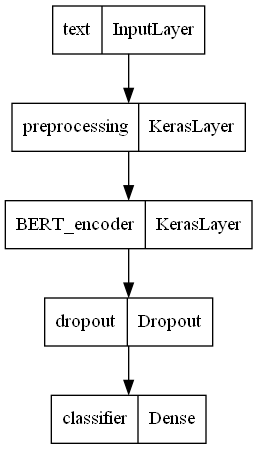

In [11]:
tf.keras.utils.plot_model(classifier_model)


In [12]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()


In [13]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')


In [14]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)


In [15]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)


Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1
Epoch 1/5
1385/1385 [==============================] - 278s 198ms/step - loss: 0.5030 - binary_accuracy: 0.7698 - val_loss: 0.3837 - val_binary_accuracy: 0.8232
Epoch 2/5
1385/1385 [==============================] - 267s 193ms/step - loss: 0.3886 - binary_accuracy: 0.8239 - val_loss: 0.3336 - val_binary_accuracy: 0.8544
Epoch 3/5
1385/1385 [==============================] - 270s 195ms/step - loss: 0.3440 - binary_accuracy: 0.8476 - val_loss: 0.3111 - val_binary_accuracy: 0.8707
Epoch 4/5
1385/1385 [==============================] - 277s 200ms/step - loss: 0.3160 - binary_accuracy: 0.8617 - val_loss: 0.2958 - val_binary_accuracy: 0.8772
Epoch 5/5
1385/1385 [==============================] - 281s 203ms/step - loss: 0.3006 - binary_accuracy: 0.8685 - val_loss: 0.2925 - val_binary_accuracy: 0.8816


In [16]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')


194/194 [==============================] - 28s 143ms/step - loss: 0.2746 - binary_accuracy: 0.8873
Loss: 0.27462995052337646
Accuracy: 0.887271523475647


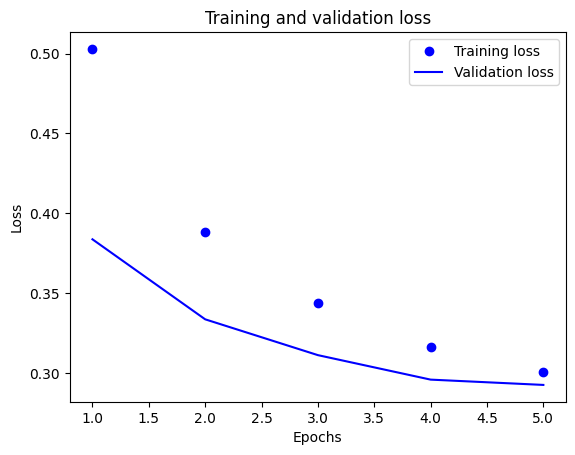

In [18]:
history_dict = history.history
history_dict.keys()
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
